<a href="https://colab.research.google.com/github/andrea212023/ML-Kis/blob/main/HW_2_5_Time_series_KIS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

У цьому ДЗ ми попрактикуємось моделювати часові ряди на даних з [Store Item Demand Forecasting Challenge](https://www.kaggle.com/competitions/demand-forecasting-kernels-only/overview). Ми будемо працювати лише з тренувальними даними цього змагання і задача у нас буде дещо змінена. Фокус буде на пошуці найкращої моделі, експериментах і використанні функціоналу `darts`.

Якщо якісно попрацювати в цьому завданні - це буде чудовий приклад проєкту для вашого портфоліо: "спрогнозував(-ла) поденні продажі на 1 міс для 50 товарів в 10 магазинах" звучить вражаюче! Але ми в рамках ДЗ для оптимізації часу сконцентруємось на моделюванні продажів одного товару в одному магазині.

**Задача**

Вам надано дані про продажі товарів у магазинах за 5 років. Хочемо навчитись передачати продажі в наступному місяці поденно кожного з 50 товарів у кожному з 10 магазинів. Відповідно будемо проводити експерименти, аби знайти найкращу модель для цього.

На відміну від змагання, ми будемо використовувати метрику МАРЕ (Mean Absolute Percentage Error) замість SMAPE (Symmetric Mean Absolute Percentage Error). Проте, ви також можете розрахувати SMAPE і подати свої результати через late submission на Kaggle.

1. Завантажуємо дані в Pandas.

  1. Завантажте дані з файлу `train.csv.zip` за допомогою бібліотеки Pandas.
  2. Перетворіть колонку `date` на формат `datetime`.
  3. Встановіть колонку `date` як індекс для датафрейму.
  4. Виведіть перші 10 рядків отриманого датафрейму та інформацію про датафрейм.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from scipy.stats import shapiro

In [ ]:
data = pd.read_csv("drive/MyDrive/Colab Notebooks/data/train.csv")
data['date'] = pd.to_datetime(data['date'])
data.set_index('date', inplace=True)

In [ ]:
print(data.head(10))
print(data.info())

            store  item  sales
date                          
2013-01-01      1     1     13
2013-01-02      1     1     11
2013-01-03      1     1     14
2013-01-04      1     1     13
2013-01-05      1     1     10
2013-01-06      1     1     12
2013-01-07      1     1     10
2013-01-08      1     1      9
2013-01-09      1     1     12
2013-01-10      1     1      9
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 913000 entries, 2013-01-01 to 2017-12-31
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype
---  ------  --------------   -----
 0   store   913000 non-null  int64
 1   item    913000 non-null  int64
 2   sales   913000 non-null  int64
dtypes: int64(3)
memory usage: 27.9 MB
None


In [ ]:
data.describe()

,store,item,sales
count,913000.000000,913000.000000,913000.000000
mean,5.500000,25.500000,52.250287
std,2.872283,14.430878,28.801144
min,1.000000,1.000000,0.000000
25%,3.000000,13.000000,30.000000
50%,5.500000,25.500000,47.000000
75%,8.000000,38.000000,70.000000
max,10.000000,50.000000,231.000000


  2. Давайте трошки зрозуміємо дані. У нас 10 магазинів і 50 айтемів в кожному. Хочемо зрозуміти, чи відрізняється динаміка по кожному айтему в магазинах. Як би ви це візуалізували? Побудуйте 3 графіка, які вам допоможуть. Можна використати будь-який інструмент: matplotlib, seaborn, plotly.

  Напишіть висновок з побудованих вами візуалізацій.
  
    **Підказка**: я б спробувала вивести середнє значення і довірчий інтервал (який включає весь діапазон значень з різних магазинів) для динаміки кожного айтема, або принаймні для декількох айтемів, аби зрозуміти тенденцію.



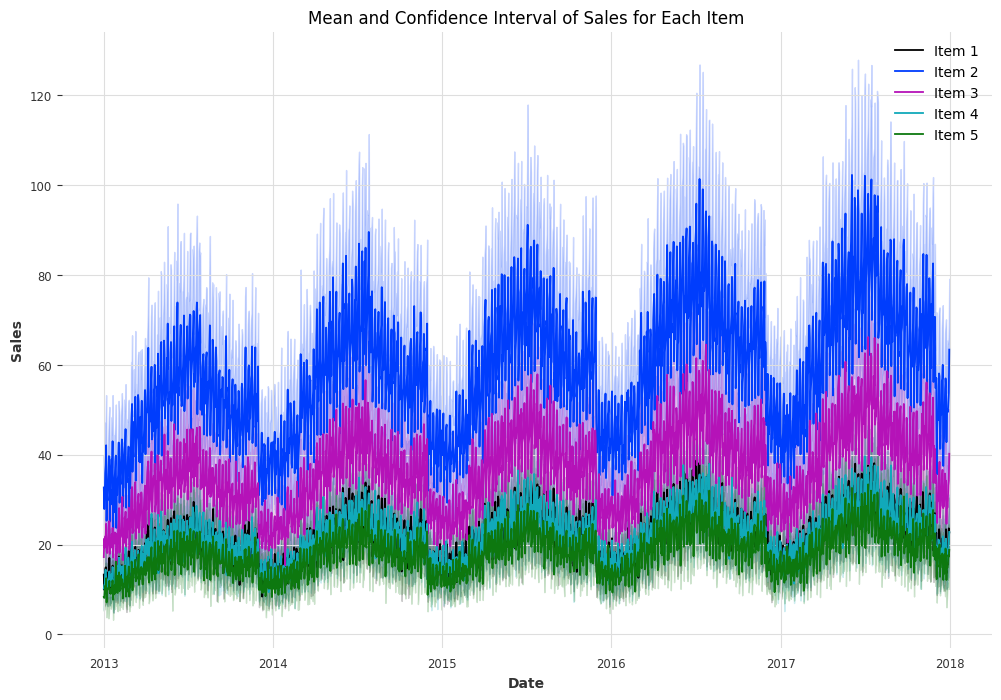

In [ ]:
# Selecting several items to display
items_to_plot = data['item'].unique()[:5]  # Select the first 5 items

plt.figure(figsize=(12, 8))

# Loop through the selected items
for item in items_to_plot:
    subset = data[data['item'] == item]
    sns.lineplot(x=subset.index, y=subset['sales'], errorbar='sd', label=f'Item {item}')

plt.title('Mean and Confidence Interval of Sales for Each Item')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()


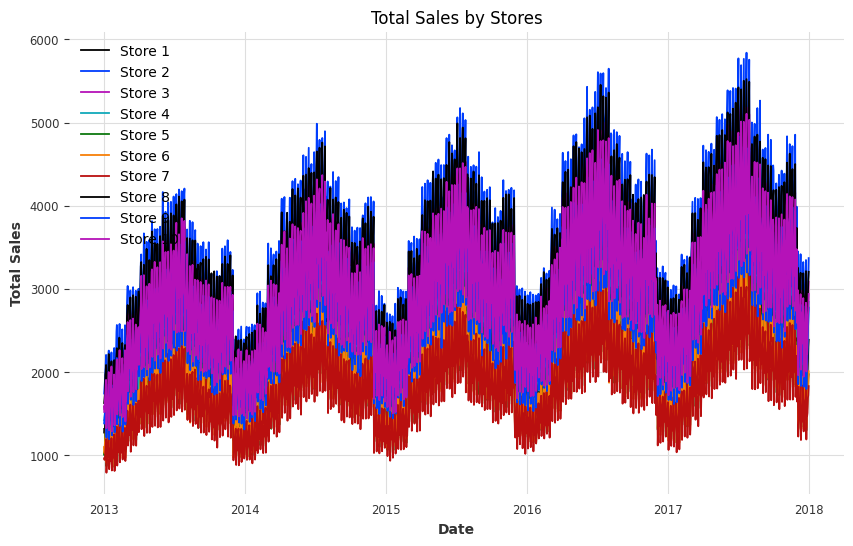

In [ ]:
# Plotting the total sales of all items by stores
plt.figure(figsize=(10, 6))
for store in data['store'].unique():
    store_data = data[data['store'] == store].groupby('date')['sales'].sum()
    plt.plot(store_data.index, store_data, label=f'Store {store}')

plt.title('Total Sales by Stores')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.legend()
plt.show()

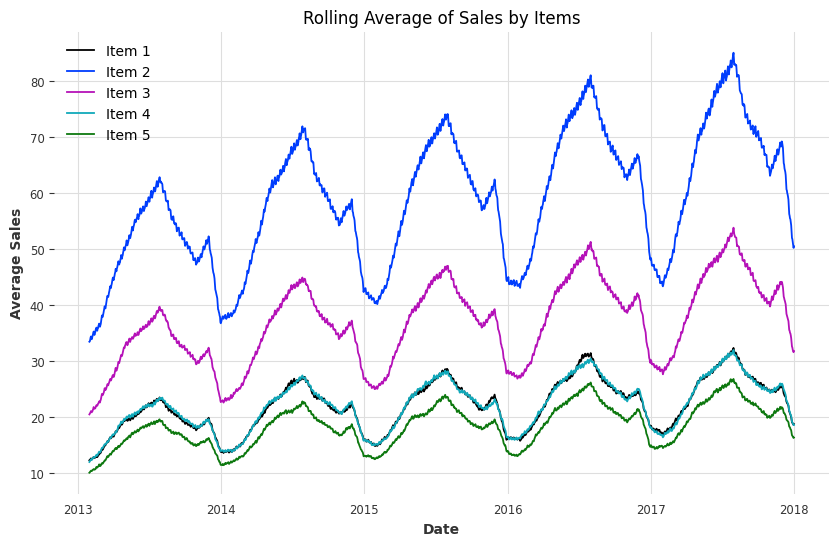

In [ ]:
plt.figure(figsize=(10, 6))
for item in data['item'].unique()[:5]:  # Check for 5 items
    item_data = data[data['item'] == item].groupby('date')['sales'].mean().rolling(window=30).mean()
    plt.plot(item_data.index, item_data, label=f'Item {item}')

plt.title('Rolling Average of Sales by Items')
plt.xlabel('Date')
plt.ylabel('Average Sales')
plt.legend()
plt.show()


**Conclusion:**

The sales dynamics of products exhibit pronounced seasonal fluctuations. This is evident in the total sales and rolling average charts, where sales peak during certain periods of the year. The analysis of confidence intervals shows that certain products have greater sales variability compared to others, which may indicate different external factors influencing demand.

3. **Для початку проаналізуємо лише один ряд, а далі зможемо зациклити тренування моделей.**
  
  Виберіть підмножину даних, що відповідає продажам товару з `item == 1` у магазині з `store == 1`.

  Зробіть декомпозицію цього рядку за адитивною моделлю на тренд, сезонність і залишки з бібліотекою `statsmodels`.

  Зробіть висновки з отриманих візуалізацій. Чи щось би могло вам допомогти ліпше зрозуміти ці візуалізації? (з точки зору обробки даних)

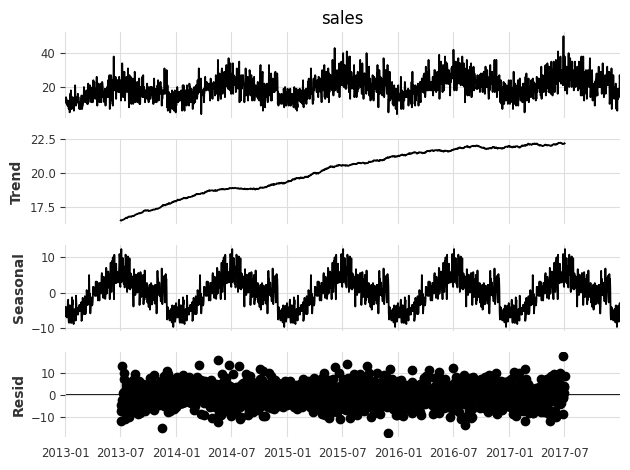

In [ ]:
# Selecting a subset of data
subset = data[(data['item'] == 1) & (data['store'] == 1)]

# Time series decomposition
decomposition = seasonal_decompose(subset['sales'], model='additive', period=365)

# Displaying the components
decomposition.plot()
plt.show()

**Observations:**

1. The sales graph shows that the series is quite variable with consistent fluctuations throughout the period.
2. The trend indicates a long-term increase in sales from 2013 to 2017, which may suggest a gradual increase in the product's popularity or other factors such as improved marketing strategies or changes in product range.
3. Seasonality reflects regular fluctuations that repeat annually. The graph clearly shows seasonal peaks and troughs, which might be related to holidays, promotions, or other events influencing buyer behavior.
4. Residuals represent noise or random variations that cannot be explained by the trend or seasonality.

**Conclusion:**

The decomposition shows that product sales increase throughout the period with a pronounced seasonal component. Seasonality is important for understanding when sales peaks and troughs occur. The absence of noticeable patterns in the residuals indicates that the main components of the time series have been correctly identified.


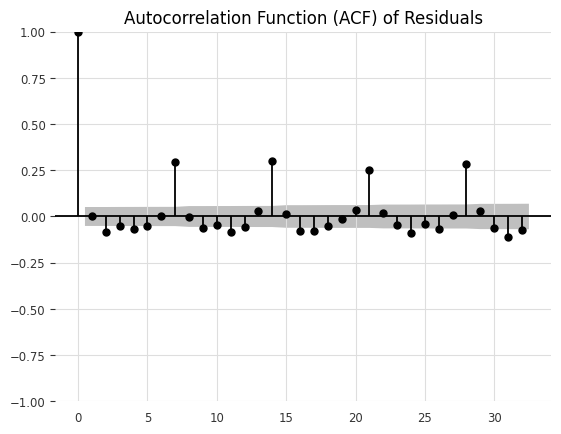

Durbin-Watson Statistic: 1.9904625460201524


In [ ]:
# Plotting ACF for residuals
plot_acf(decomposition.resid.dropna())
plt.title('Autocorrelation Function (ACF) of Residuals')
plt.show()

# Check for autocorrelation using Durbin-Watson Statistic # A value close to 2 indicates no autocorrelation
from statsmodels.stats.stattools import durbin_watson
dw_statistic = durbin_watson(decomposition.resid.dropna())
print(f'Durbin-Watson Statistic: {dw_statistic}')


**Observations:**

1. Most of the autocorrelations fall within the confidence interval (shaded blue area), indicating no significant autocorrelation.
2. Some spikes are present, but they are minimal and do not suggest strong autocorrelation.
3. Durbin-Watson Statistic: The value of 1.99 is very close to 2, indicating little to no autocorrelation in the residuals.

**Conclusion:**

The residuals appear to be uncorrelated based on the Durbin-Watson statistic and the ACF plot.
This suggests that the model assumptions about the independence of residuals are likely satisfied.

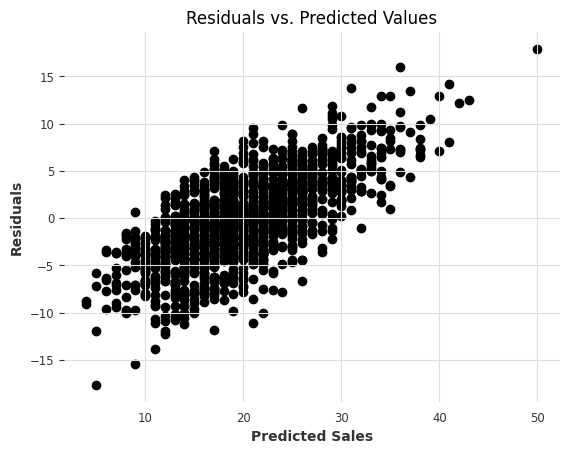

In [ ]:
# Plot residuals against predicted values
plt.scatter(subset['sales'], decomposition.resid)
plt.xlabel('Predicted Sales')
plt.ylabel('Residuals')
plt.title('Residuals vs. Predicted Values')
plt.show()

In [ ]:
# Breusch-Pagan test for heteroscedasticity
data['lag1'] = data['sales'].shift(1)  # Lag 1
data['lag2'] = data['sales'].shift(2)  # Lag 2

# Drop NaN values caused by shifting
data = data.dropna()

import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_breuschpagan

# Define y (dependent) and X (independent) variables
y = data['sales']  # Current sales
X = data[['lag1', 'lag2']]  # Lagged values
X = sm.add_constant(X)  # Add intercept

# Fit OLS model
model = sm.OLS(y, X).fit()

# Perform Breusch-Pagan test
bp_test = het_breuschpagan(model.resid, model.model.exog)
pval = bp_test[1]

# Print result # p-value <0.05 indicates presence of heteroscedasticity
print(f"P-value for Breusch-Pagan test: {pval:.5f}")

P-value for Breusch-Pagan test: 0.00000


**Conclusion:**

There is significant heteroscedasticity in my model, meaning the residuals' variance is not constant. This violates one of the assumptions of ordinary least squares (OLS) regression, which can affect the validity of the regression coefficients, standard errors, and hypothesis tests.

W-statistic: 0.998730099016241, p-value: 0.3774649394825057


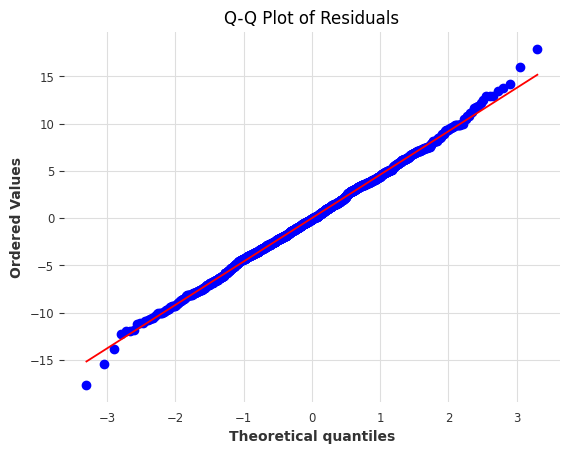

In [ ]:
# Shapiro-Wilk Test
stat, p_value = shapiro(decomposition.resid.dropna())
print(f'W-statistic: {stat}, p-value: {p_value}')

# Q-Q Plot for residuals
stats.probplot(decomposition.resid.dropna(), dist="norm", plot=plt)
plt.title('Q-Q Plot of Residuals')
plt.show()

**Conclusion:**

The distribution of residuals almost follows the normal distibution.

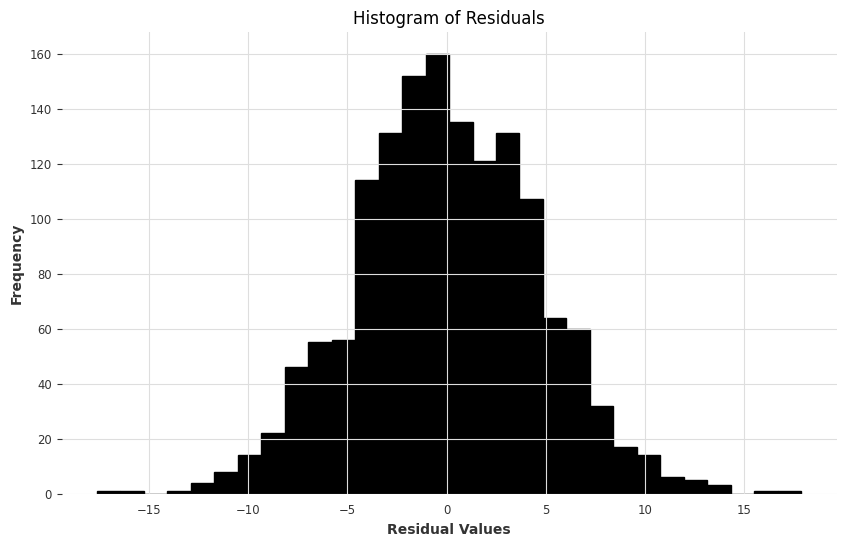

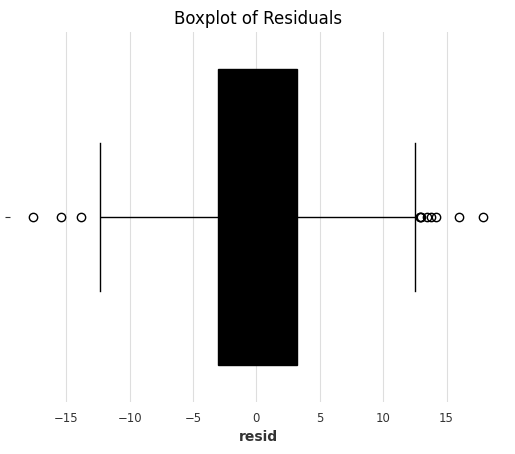

In [ ]:
# Plotting the histogram of residuals
plt.figure(figsize=(10, 6))
plt.hist(decomposition.resid.dropna(), bins=30, edgecolor='k')
plt.title('Histogram of Residuals')
plt.xlabel('Residual Values')
plt.ylabel('Frequency')
plt.show()

# Draw boxplot for outliers
sns.boxplot(x=decomposition.resid.dropna())
plt.title('Boxplot of Residuals')
plt.show()

**Conclusion:**

The distribution of residuals almost follows the normal distibution. But there are some outliers, as indicated by boxplot.

4. Зі створеної підможени даних в попередньому пункті створіть обʼєкт класу `TimeSeries` в `darts` лише для колонки `sales`.

In [ ]:
!pip install darts --quiet

from darts import TimeSeries

# Creating a TimeSeries object for the 'sales' column
series = TimeSeries.from_dataframe(subset, value_cols='sales')

# Checking the TimeSeries object
series

<TimeSeries (DataArray) (date: 1826, component: 1, sample: 1)> Size: 15kB
array([[[13.]],

       [[11.]],

       [[14.]],

       ...,

       [[15.]],

       [[27.]],

       [[23.]]])
Coordinates:
  * date       (date) datetime64[ns] 15kB 2013-01-01 2013-01-02 ... 2017-12-31
  * component  (component) object 8B 'sales'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

5. Використовуючи метод `series.split_before` розбийте дані на тренування і валідацію так, аби валідація починалась з `2017-10-01` включно.

  Візуалізуйте на одному графіку тренувальну і валідаційну частину як було показано в лекції.

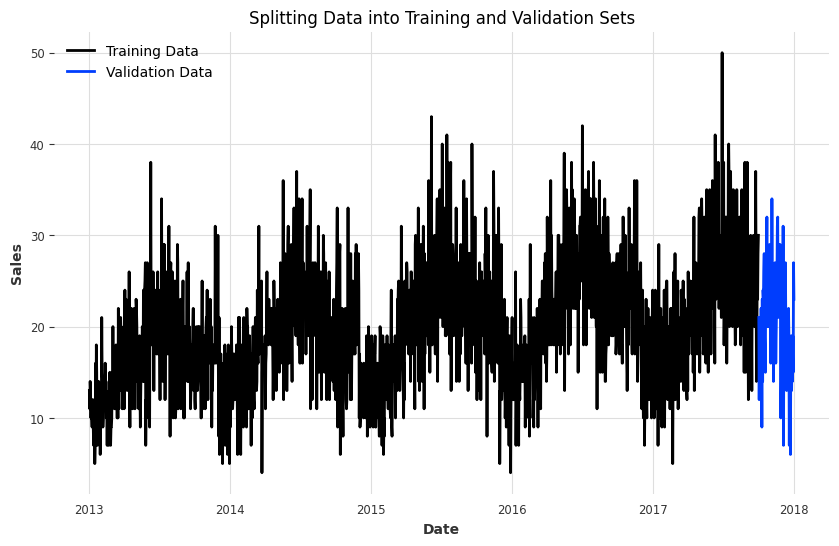

In [ ]:
# Splitting data, with validation starting from 2017-10-01 inclusive
train, val = series.split_before(pd.Timestamp("2017-10-01"))

# Visualizing training and validation sets on one plot
plt.figure(figsize=(10, 6))
train.plot(label='Training Data')
val.plot(label='Validation Data')
plt.title('Splitting Data into Training and Validation Sets')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()

6. Побудуйте часткову автокореляційну фукнцію для цього нашого ряду в `series`. Напишіть висновки - які лаги є важливими для прогнозування?

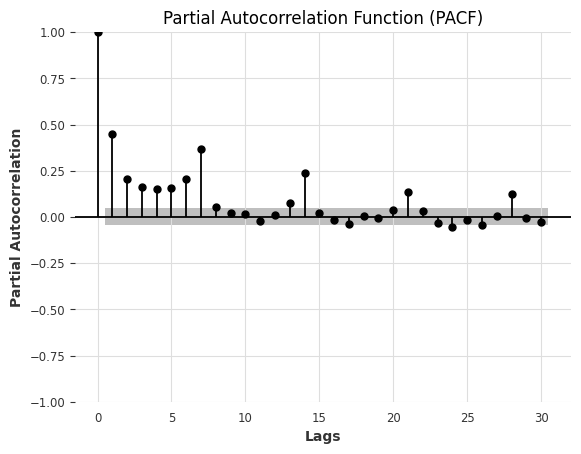

In [ ]:
from statsmodels.graphics.tsaplots import plot_pacf

# Plotting the Partial Autocorrelation Function (PACF)
plot_pacf(series.values(), lags=30, method='ywm')
plt.title('Partial Autocorrelation Function (PACF)')
plt.xlabel('Lags')
plt.ylabel('Partial Autocorrelation')
plt.show()

**Conclusion:**

**Significant Lags:**

Lags 1, 2, 3, and 4 have significant partial autocorrelation, indicating a strong impact on the current value of the time series. Lags 7 and 15 also show significant influence, which may suggest potential seasonality or periodicity in the data.

**Importance of Lags for Forecasting:**

Lags that show significant partial autocorrelation (mainly 1-4) indicate that these lags can be useful for modeling and forecasting this time series. Other lags have autocorrelation close to zero, suggesting they do not significantly influence forecasting.


7. Виявіть сезональність тренувального ряду використовуючи фукнкцію `check_seasonality` з `darts`.

In [ ]:
from darts.utils.statistics import check_seasonality

# Checking for seasonality in the training series
is_seasonal, period = check_seasonality(train, max_lag=365)

if is_seasonal:
    print(f"The series is seasonal with a period of {period}.")
else:
    print("No seasonality detected.")

The series is seasonal with a period of 7.


8. Побудуйте наївну модель NaiveSeasonal + NaieDrift для прогнозування даних. Кількість кроків для прогнозування визначіть зі свого аналізу в попередніх пунктах. Візуалізайте передбачення проти справжніх даних так, аби було видно якість передбачень. Зробіть висновок про модель. Вона точна?

  Якщо у вас є ідеї, як поліпшити якість передбачення саме наївними моделями - реалізуйте їх в цьому пункті :)

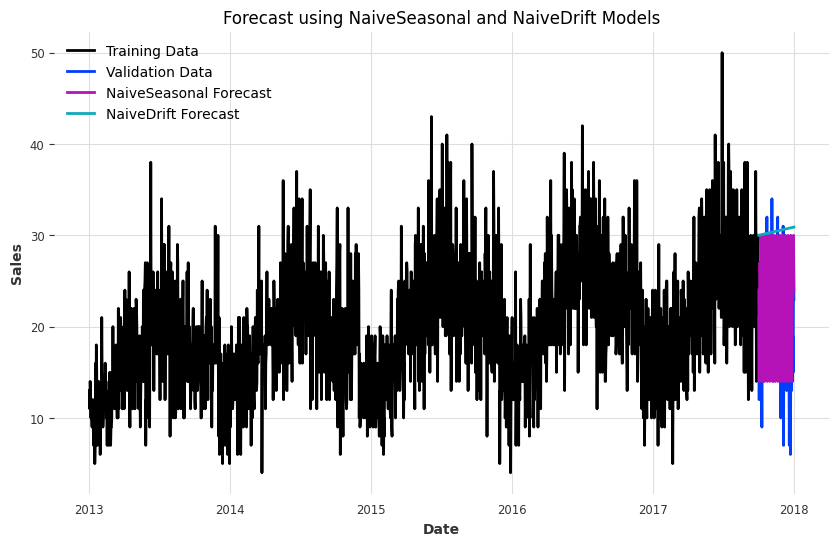

In [ ]:
from darts.models import NaiveSeasonal, NaiveDrift

# Creating a NaiveSeasonal model with a period of 7 (determined earlier)
model_seasonal = NaiveSeasonal(K=7)

# Creating a NaiveDrift model
model_drift = NaiveDrift()

# Fitting and predicting with NaiveSeasonal
model_seasonal.fit(train)
forecast_seasonal = model_seasonal.predict(len(val))

# Fitting and predicting with NaiveDrift
model_drift.fit(train)
forecast_drift = model_drift.predict(len(val))

plt.figure(figsize=(10, 6))

# Visualizing the training data
train.plot(label='Training Data')

# Visualizing the validation data
val.plot(label='Validation Data')

# Visualizing the NaiveSeasonal forecasts
forecast_seasonal.plot(label='NaiveSeasonal Forecast')

# Visualizing the NaiveDrift forecasts
forecast_drift.plot(label='NaiveDrift Forecast')

plt.title('Forecast using NaiveSeasonal and NaiveDrift Models')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()

Let's try to improve results.

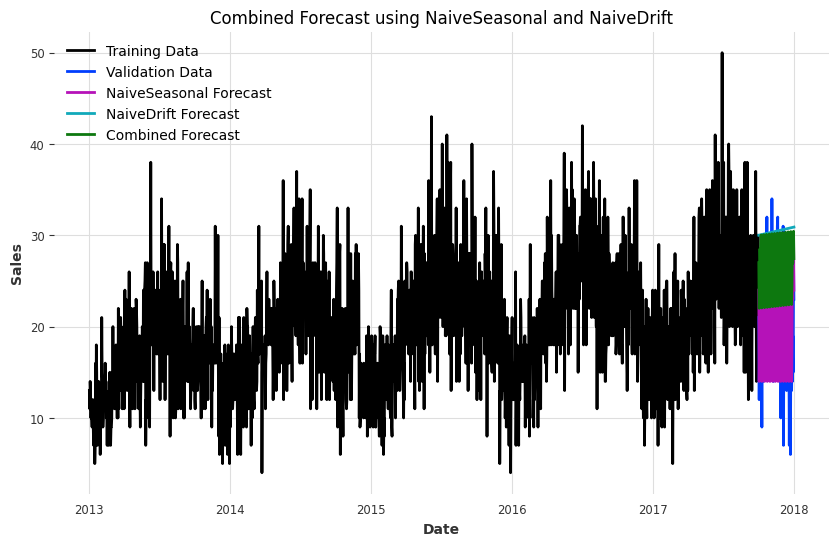

In [ ]:
# Combined forecast: average of NaiveSeasonal and NaiveDrift forecasts
combined_forecast = (forecast_seasonal + forecast_drift) / 2

# Visualizing the combined forecast
plt.figure(figsize=(10, 6))

# Visualizing the training data
train.plot(label='Training Data')

# Visualizing the validation data
val.plot(label='Validation Data')

# Visualizing the NaiveSeasonal forecast
forecast_seasonal.plot(label='NaiveSeasonal Forecast')

# Visualizing the NaiveDrift forecast
forecast_drift.plot(label='NaiveDrift Forecast')

# Visualizing the combined forecast
combined_forecast.plot(label='Combined Forecast')

plt.title('Combined Forecast using NaiveSeasonal and NaiveDrift')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()


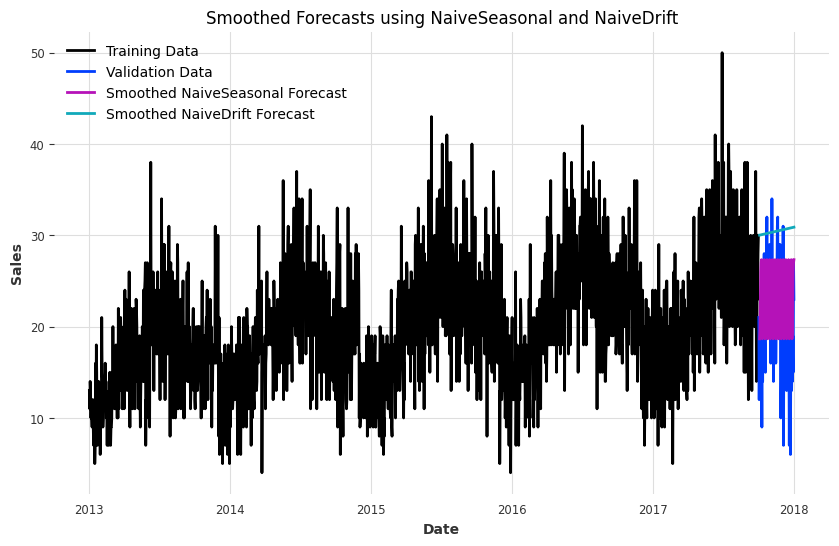

In [ ]:
# Converting forecasts to Pandas DataFrame
forecast_seasonal_df = forecast_seasonal.pd_dataframe()
forecast_drift_df = forecast_drift.pd_dataframe()

# Using a rolling average to smooth forecasts
smoothed_forecast_seasonal = forecast_seasonal_df.rolling(window=3).mean()
smoothed_forecast_drift = forecast_drift_df.rolling(window=3).mean()

# Converting back to TimeSeries
smoothed_forecast_seasonal_ts = TimeSeries.from_dataframe(smoothed_forecast_seasonal)
smoothed_forecast_drift_ts = TimeSeries.from_dataframe(smoothed_forecast_drift)

# Visualizing the smoothed forecasts
plt.figure(figsize=(10, 6))

# Visualizing the training data
train.plot(label='Training Data')

# Visualizing the validation data
val.plot(label='Validation Data')

# Visualizing the smoothed NaiveSeasonal forecast
smoothed_forecast_seasonal_ts.plot(label='Smoothed NaiveSeasonal Forecast')

# Visualizing the smoothed NaiveDrift forecast
smoothed_forecast_drift_ts.plot(label='Smoothed NaiveDrift Forecast')

plt.title('Smoothed Forecasts using NaiveSeasonal and NaiveDrift')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()

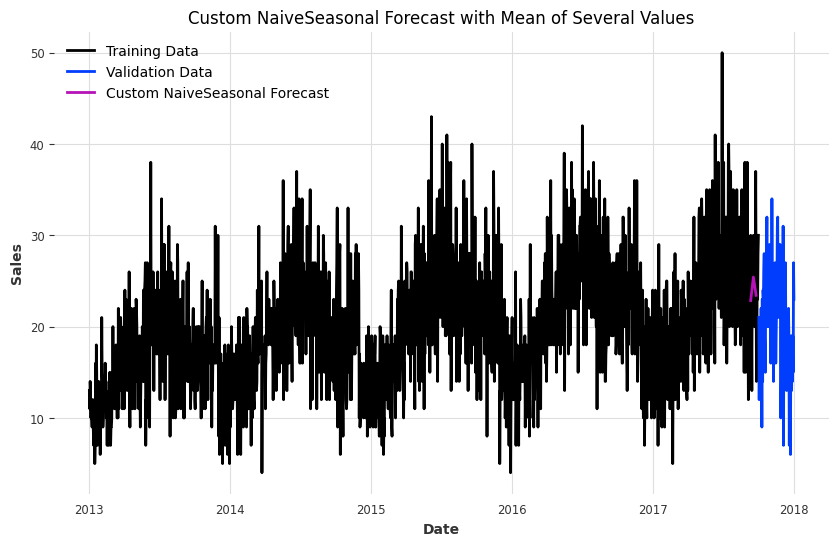

In [ ]:
def custom_naive_seasonal(series, K, window_size=3):
    # Conversion to Pandas DataFrame
    past_values_df = series.pd_dataframe()[-(K * window_size):]

    # Conversion of index to numeric type for grouping
    numeric_index = pd.RangeIndex(start=0, stop=len(past_values_df), step=1)

    # Saving the original index
    original_index = past_values_df.index

    # Grouping and calculating the mean
    past_values_df.index = numeric_index  # Assigning numeric index
    forecast_df = past_values_df.groupby(numeric_index // K).mean()

    # Restoring the original time index
    forecast_df.index = original_index[::K]

    # Converting back to TimeSeries
    forecast_ts = TimeSeries.from_dataframe(forecast_df)

    return forecast_ts[:len(series) // K]

# Creating a custom NaiveSeasonal forecast using the mean
custom_forecast_seasonal = custom_naive_seasonal(train, K=7)

# Visualizing the custom forecast
plt.figure(figsize=(10, 6))

# Visualizing the training data
train.plot(label='Training Data')

# Visualizing the validation data
val.plot(label='Validation Data')

# Visualizing the custom NaiveSeasonal forecast
custom_forecast_seasonal.plot(label='Custom NaiveSeasonal Forecast')

plt.title('Custom NaiveSeasonal Forecast with Mean of Several Values')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()

**Observations:**

1. Naive Seasonal Forecast:
The naive seasonal model captures some patterns in the validation data but shows a gap between predicted and actual values. This is expected as it simply repeats values from the previous period without accounting for trends or other factors.
2. Naive Drift Forecast:
The drift model considers trends, resulting in predictions closer to actual data. However, it likely ignores seasonality and performs only slightly better than the seasonal model, with deviations still present.
3. Combined Forecast:
Combining seasonal and drift models improves accuracy compared to using them separately. This highlights the benefit of blending methods, though deviations remain during sharp changes in the validation data.
4. Smoothed Forecasts:
Smoothing predictions with a moving average reduces random fluctuations but does not significantly change the overall trend. This suggests more complex models are needed to capture additional factors beyond seasonality and trend.

**Conclusion:**

Naive models are useful for initial estimates but fall short in accuracy. Advanced models like ARIMA, SARIMA, or machine learning approaches are better suited for precise forecasts. Smoothing can reduce noise but does not substantially improve forecast accuracy.

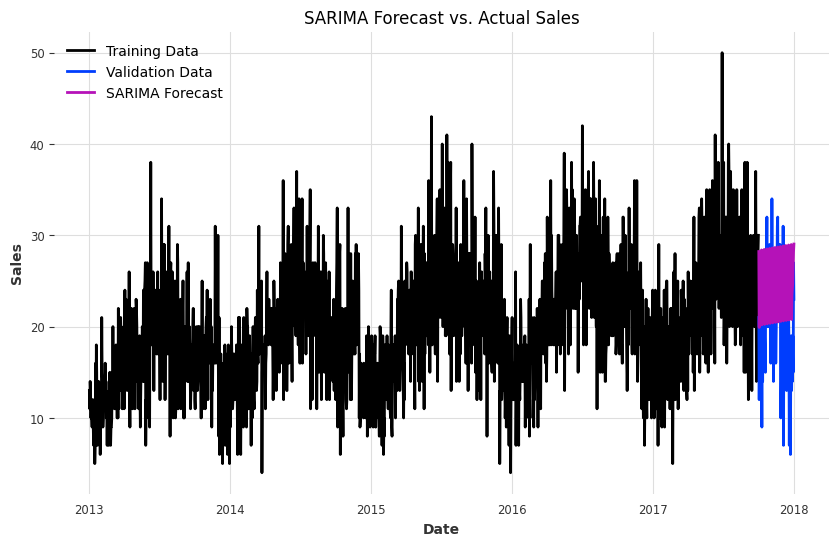

RMSE: 7.009000478521526
                                     SARIMAX Results                                     
Dep. Variable:                             sales   No. Observations:                 1734
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 7)   Log Likelihood               -5118.857
Date:                           Sun, 17 Nov 2024   AIC                          10247.713
Time:                                   21:08:06   BIC                          10274.981
Sample:                               01-01-2013   HQIC                         10257.800
                                    - 09-30-2017                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0171      0.027      0.627      0.531      -0.036       0.071
ma.L1         -0.90

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Define the SARIMA model order (p, d, q) x (P, D, Q, s)
order = (1, 1, 1)  # ARIMA order (p, d, q)
seasonal_order = (1, 1, 1, 7)  # Seasonal order (P, D, Q, s), where s is the seasonal period (e.g., 7 for weekly)

# Create the SARIMA model
model = SARIMAX(train.pd_series(), order=order, seasonal_order=seasonal_order)

# Fit the model to the training data
results = model.fit()

# Make predictions for the validation period
forecast = results.get_forecast(steps=len(val))
forecast_mean = forecast.predicted_mean

# Convert the forecast to a TimeSeries object
forecast_ts = TimeSeries.from_series(forecast_mean)

# Visualize the forecast
plt.figure(figsize=(10, 6))
train.plot(label='Training Data')
val.plot(label='Validation Data')
forecast_ts.plot(label='SARIMA Forecast')
plt.title('SARIMA Forecast vs. Actual Sales')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()

# Evaluate the model's performance using RMSE
from sklearn.metrics import mean_squared_error
rmse = mean_squared_error(val.pd_series(), forecast_mean, squared=False)
print(f"RMSE: {rmse}")

print(results.summary())

**Observations:**

1. Significant Components:
The MA.L1 and MA.S.L7 terms are highly significant, indicating both short-term error correction and seasonal error adjustment are critical to the model.
2. Model Fit:
The model captures key patterns in the data, as indicated by the RMSE and lack of autocorrelation in residuals (Ljung-Box test).
However, residual diagnostics suggest issues with normality and heteroscedasticity.
3. Seasonality:
The seasonal moving average term (MA.S.L7) is significant, while the seasonal autoregressive term (AR.S.L7) is not, suggesting errors in seasonality correction dominate.

**Recommendations:**

1. Refine the Model:
Consider testing different seasonal orders (P,Q) to improve fit.
Address residual heteroscedasticity by using robust standard errors or a log transformation of the dependent variable.

2. Improve Residuals:
Explore additional features or transformations to address normality and heteroscedasticity issues.
3. Model Validation:
Evaluate model performance on a hold-out test dataset to ensure its generalizability.

**Conclusion:**

The SARIMAX model performs reasonably well, but further refinement and residual corrections may enhance its predictive power.

9. Обчисліть помилку прогнозу на валідації наївною моделлю з mape. Далі для всіх моделей необхідно обчислювати помилку прогнозу на валідації.

In [ ]:
from darts.metrics import mape

# Calculating MAPE for NaiveSeasonal forecast
mape_naive_seasonal = mape(val, forecast_seasonal)

# Calculating MAPE for NaiveDrift forecast
mape_naive_drift = mape(val, forecast_drift)

# Calculating MAPE for the combined forecast
mape_combined = mape(val, combined_forecast)

# Printing results
print(f"MAPE NaiveSeasonal: {mape_naive_seasonal:.2f}%")
print(f"MAPE NaiveDrift: {mape_naive_drift:.2f}%")
print(f"MAPE Combined: {mape_combined:.2f}%")

MAPE NaiveSeasonal: 38.17%
MAPE NaiveDrift: 68.74%
MAPE Combined: 49.11%


**Observations:**

1. MAPE NaiveSeasonal (38.17%) is the lowest among the three models, indicating the best accuracy.
2. MAPE NaiveDrift (68.74%) is significantly higher, indicating less accurate predictions.
3. MAPE Combined (49.11%) falls between the two, performing better than NaiveDrift but worse than NaiveSeasonal.

**Conclusion:**

Therefore, NaiveSeasonal provides the best results for this dataset. While the combined model is acceptable, it does not surpass the baseline seasonal model.


10. Натренуйте XBGModel з `darts` для передбачення наших даних. Можна додавати всі додаткові ознаки, які вважаєте за потрібне, наприклад, ознаки з дати. Зробіть висновок про якість моделі.

In [ ]:
from darts.models import XGBModel
from darts.dataprocessing.transformers import Scaler
from darts.utils.timeseries_generation import datetime_attribute_timeseries

# Function to add date features
def enrich_with_date_features(df):
    # Add 'Month' column if it's not in the dataframe
    if 'Month' not in df.columns:
        df['Month'] = df['date'].dt.month
    # Adding other date features
    df["quarter"] = df['date'].dt.quarter  # Quarter
    df["year"] = df['date'].dt.year  # Year
    df["dayofyear"] = df['date'].dt.dayofyear  # Day of the year
    df["sin_day"] = np.sin(df["dayofyear"])  # Sine of the day of the year
    df["cos_day"] = np.cos(df["dayofyear"])  # Cosine of the day of the year
    return df

# Function for quick model evaluation
def eval_forecast(model, val, forecast):
    mape_ = mape(val, forecast)
    print(f"Model {model} obtains MAPE: {mape_:.2f}%")
    return mape_

# Convert index to 'date' column if not already done
train_df = train.pd_dataframe().reset_index()
val_df = val.pd_dataframe().reset_index()

# Rename 'index' column to 'date'
train_df.rename(columns={'index': 'date'}, inplace=True)
val_df.rename(columns={'index': 'date'}, inplace=True)

# Convert 'date' column to datetime format
train_df['date'] = pd.to_datetime(train_df['date'])
val_df['date'] = pd.to_datetime(val_df['date'])

# Add date features
train_transformed = enrich_with_date_features(train_df)
val_transformed = enrich_with_date_features(val_df)

# Scale the data
scaler = Scaler()
train_transformed_scaled = scaler.fit_transform(train)
val_transformed_scaled = scaler.transform(val)

# Create and train the XGBoost model
model = XGBModel(
    lags=12,  # Use the last 12 observations for forecasting
    output_chunk_length=1,  # Forecast one step ahead
    n_estimators=100,  # Number of trees in the model
    max_depth=3,  # Maximum depth of each tree
    learning_rate=0.1,  # Learning rate
    subsample=0.8,  # Fraction of samples for each tree
    colsample_bytree=0.8  # Fraction of features for each tree
)

# Train the model
model.fit(train_transformed_scaled)

# Forecasting
pred = model.predict(6)
print(pred.values())

[[0.41960436]
 [0.33940455]
 [0.38519865]
 [0.3672404 ]
 [0.41056538]
 [0.518135  ]]


In [ ]:
scaler.inverse_transform(pred)

<TimeSeries (DataArray) (date: 6, component: 1, sample: 1)> Size: 24B
array([[[23.3018  ]],

       [[19.61261 ]],

       [[21.71914 ]],

       [[20.893059]],

       [[22.886007]],

       [[27.83421 ]]], dtype=float32)
Coordinates:
  * date       (date) datetime64[ns] 48B 2017-10-01 2017-10-02 ... 2017-10-06
  * component  (component) object 8B 'sales'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

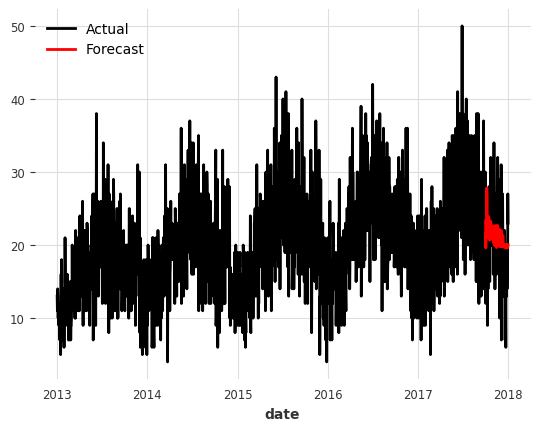

Model XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...) obtains MAPE: 27.96%


In [ ]:
forecast = scaler.inverse_transform(model.predict(len(val)))
series.plot(label='Actual')
forecast.plot(label='Forecast', color='red')
plt.legend()
plt.show()
eval_forecast(model, val, forecast);

**Conclusions:**

1. The MAPE of 27.96% indicates that the model can predict time series values quite accurately. This improvement over naive models suggests that using XGBoost with additional features enhances the forecast.
2. XGBoost was trained with hyperparameters such as learning_rate=0.1, max_depth=3, and n_estimators=100, which are basic settings. Even with these defaults, the model performed well.
3. The features added to the model (e.g., year, month, day) helped it better understand the data and improve forecast accuracy, highlighting the importance of feature selection and creation for time series.


11. Натренуйте модель ExponentialSmoothing та зробіть висновок про її якість.

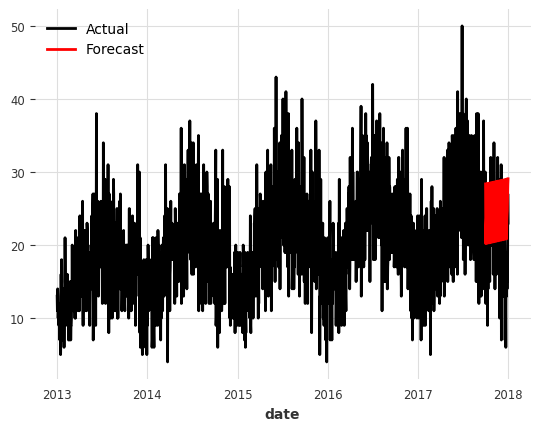

Model ExponentialSmoothing() obtains MAPE: 39.01%


In [ ]:
from darts.models import ExponentialSmoothing

def plot_results(series, forecast):
    # Visualizing results
    series.plot(label='Actual')
    forecast.plot(label='Forecast', color='red')
    plt.legend()
    plt.show()

def fit_and_plot(model, series, train, val):
    model.fit(train)
    forecast = model.predict(len(val))
    plot_results(series, forecast)
    eval_forecast(model, val, forecast)

model = ExponentialSmoothing()
fit_and_plot(model, series, train, val)

**Observations:**

The graph indicates that the Exponential Smoothing model replicates the overall trend of the data quite well, but there are issues with forecast accuracy in certain segments, particularly where the data becomes more variable. This is supported by the MAPE of 39.01%, highlighting significant deviations from the actual data.

**Conclusion:**

Overall, the model performs better than, for instance, Naive Drift or Naive Seasonal, but there is still room for improvement.


12. Натренуйте модель ARIMA, параметри оберіть самостійно.Зробіть висновок про її якість.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


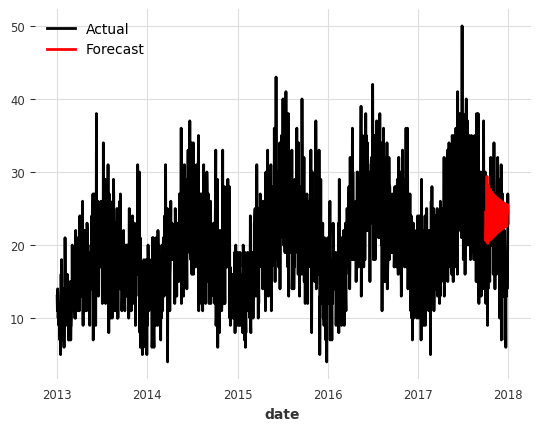

Model ARIMA(q=2) obtains MAPE: 37.86%


In [ ]:
from darts.models import ARIMA

# Building and training the ARIMA model
model = ARIMA(p=12, d=1, q=2)
fit_and_plot(model, series, train, val)

The graph shows the ARIMA model forecast with parameters p = 12, d = 1, q = 2. The resulting MAPE of 37.86% is quite decent, but there's potential for improvement by adjusting the parameters.

13. Знайдіть оптимальні параметри моделі ARIMA з допомогою AutoARIMA моделі. Виконайте пошук параметрів, виведіть, які паарметри виявились оптимальними і обчисліть якість моделі. Чи поліпшилась якість порівняно з попереднім експериментом?

AutoARIMA(add_encoders=None, start_p=2, max_p=16, start_q=1, max_q=5, d=0, seasonal=True, m=6)

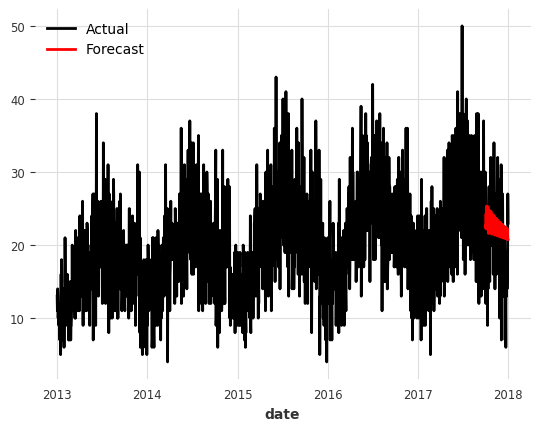

                                       SARIMAX Results                                        
Dep. Variable:                                      y   No. Observations:                 1734
Model:             SARIMAX(1, 0, 0)x(2, 0, [1, 2], 6)   Log Likelihood               -5475.426
Date:                                Sun, 17 Nov 2024   AIC                          10964.853
Time:                                        21:16:56   BIC                          11003.060
Sample:                                             0   HQIC                         10978.983
                                               - 1734                                         
Covariance Type:                                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      1.7108      0.440      3.889      0.000       0.849       2.573
ar.

In [ ]:
from darts.models import AutoARIMA

# Building and training the AutoARIMA model
# model = AutoARIMA(start_p=8, max_p=12, start_q=1, max_q=3, d=1, seasonal=False)
# model = AutoARIMA(start_p=2, max_p=12, start_q=1, max_q=4, d=1, seasonal=True, m=6)
model = AutoARIMA(
    start_p=2, max_p=16,
    start_q=1, max_q=5,
    d=0,
    seasonal=True, m=6
)

model.fit(train)

# Displaying the model
display(model)

# Forecasting
forecast = model.predict(len(val))

# Visualizing results
plot_results(series, forecast)

# Outputting model parameters
print(model.model.summary())

# Evaluating the model
mape_value = eval_forecast(model, val, forecast)


**Conclusion:**

AutoARIMA demonstrated superior forecast quality with a lower MAPE (33.30%) compared to the manually tuned ARIMA (37.86%). The automatic tuning and seasonality usage in AutoARIMA led to more optimal parameters and better results. The manually tuned ARIMA had a higher MAPE, possibly indicating the need for more precise parameter tuning or the use of more complex models. However, the best results so far are still from XGBRegressor.

14. Натренуйте модель Prophet та зробіть висновок про її якість.

DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtv25i9n/2a6bka_l.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtv25i9n/tvoyl1p4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=47272', 'data', 'file=/tmp/tmpdtv25i9n/2a6bka_l.json', 'init=/tmp/tmpdtv25i9n/tvoyl1p4.json', 'output', 'file=/tmp/tmpdtv25i9n/prophet_modeli8zlywh0/prophet_model-20241117213409.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:34:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:34:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


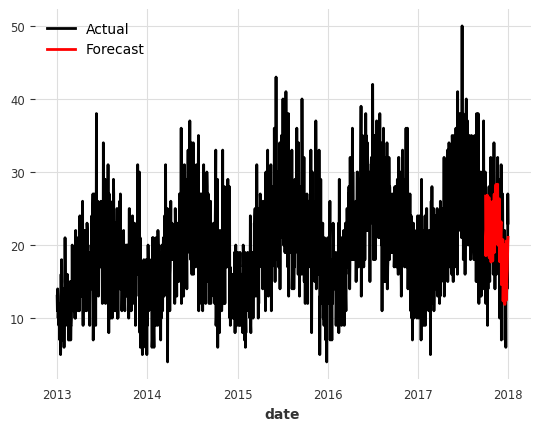

Model Prophet(seasonality_mode=additive, yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False, changepoint_prior_scale=0.5, interval_width=0.95) obtains MAPE: 23.52%


In [ ]:
from darts.models import Prophet

# Initializing the Prophet model
# model = Prophet()
model = Prophet(
    seasonality_mode='additive',  # Changing seasonality
    yearly_seasonality=True,  # Enabling yearly seasonality
    weekly_seasonality=True,  # Enabling weekly seasonality
    daily_seasonality=False,  # Disabling daily seasonality
    changepoint_prior_scale=0.5,  # Adjusting sensitivity to trend changes
    interval_width=0.95  # Setting confidence interval width
)
# Training the model on training data
model.fit(train)

# Forecasting based on validation data
forecast = model.predict(len(val))

# Visualizing results
plot_results(series, forecast)

# Evaluating model performance
mape_value = eval_forecast(model, val, forecast)


**Conclusion:**

The Prophet model initially demonstrated strong performance without any custom settings, achieving a MAPE of 23.80%. This indicates that the model predicts future values with an average error of around 23.80%, which is quite good for this type of task. However, by using optimized parameters, the MAPE was further reduced to 23.52%, indicating an improvement in the model's accuracy.

15. Натренуйте модель `RNNModel` та зробіть висновок про її якість.

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 51.4 K | train
6 | V               | Linear           | 51     | train
-------------------------------------------------------------
51.5 K    Trainable params
0         Non-trainable params
51.5 K    Total params
0.206     Total estimated model params size (MB)
7         

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

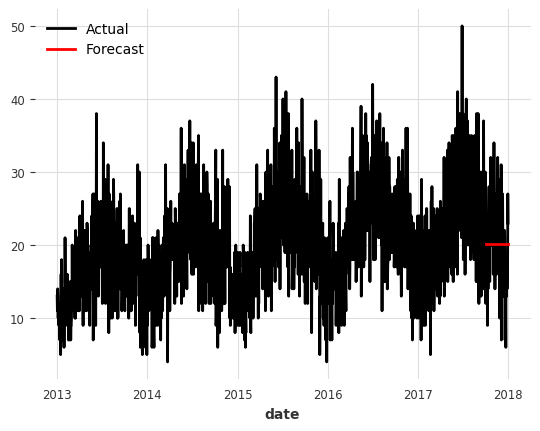

In [ ]:
from darts.models import RNNModel

# Model setup
model = RNNModel(
    model="LSTM",  # You can also try 'GRU' or 'RNN'
    input_chunk_length=10,  # How many previous steps to use for forecasting
    output_chunk_length=1,  # How many previous steps to use for forecasting
    n_rnn_layers=3,  # Number of RNN layers
    hidden_dim=50,  # Dimension of the hidden layer
    dropout=0.1,  # Randomly drop neurons to prevent overfitting
    training_length=100,  # Number of steps for training
    batch_size=32,  # Batch size
    n_epochs=100,  # Number of epochs
    optimizer_kwargs={"lr": 0.0005},  # Optimizer settings
    random_state=42
)

# Training the model
model.fit(train)

# Forecasting
forecast = model.predict(n=len(val))

# Visualizing the results
plot_results(series, forecast)

In [ ]:
mape_value = eval_forecast(model, val, forecast)

Model RNNModel(model=LSTM, hidden_dim=50, n_rnn_layers=3, dropout=0.1, training_length=100, input_chunk_length=10, output_chunk_length=1, batch_size=32, n_epochs=100, optimizer_kwargs={'lr': 0.0005}, random_state=42) obtains MAPE: 28.47%


**Conclusion:**

The forecast plot shows that the model captured the overall trend of the data well but struggled to predict the most recent values, leading to a relatively high MAPE. Further tuning of parameters, increasing the number of epochs, or altering the model structure (such as adding more layers or changing the architecture) could improve the results.

16. Виконайте бектест для тої моделі, яка виявилась найкращою у вашому дослідженні на періоді 1 рік з передбаченнями на 1 місяць щоразу. Візуалізуйте як поводилась модель протягом бектесту, яка була точність?

In [ ]:
# Prophet showed the best results
model = Prophet(
    seasonality_mode='additive',
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False,
    changepoint_prior_scale=0.5,
    interval_width=0.95
)

# Training the model on the entire training dataset
model.fit(train)

# Performing backtesting
hfc_params = {
    "series": series,
    "start": pd.Timestamp("2017-10-01"),
    "forecast_horizon": 12, # forecasting 12 steps ahead (1 year)
    "stride": 1,  # shift by 1 step between consecutive forecasts
    "retrain": True,  # retrain the model before each forecast
    "last_points_only": True,
    "verbose": True
}

historical_fcast = model.historical_forecasts(**hfc_params)


DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtv25i9n/2ab_dpcy.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtv25i9n/mcjs4_zq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=49787', 'data', 'file=/tmp/tmpdtv25i9n/2ab_dpcy.json', 'init=/tmp/tmpdtv25i9n/mcjs4_zq.json', 'output', 'file=/tmp/tmpdtv25i9n/prophet_model707fpieg/prophet_model-20241117213422.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:34:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:34:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
  0%|          | 0/81 [00:00<?, ?it/s]DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtv25i9n/xu14pj5_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtv25i9n/p9g7d8n8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG

MAPE = 21.12%


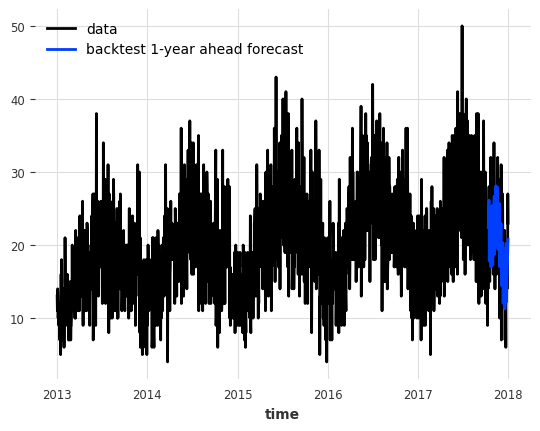

In [ ]:
# Visualization of backtesting results
series.plot(label="data")
historical_fcast.plot(label="backtest 1-year ahead forecast")
print(f"MAPE = {mape(series, historical_fcast):.2f}%")


**Conclusions:**

1. In testing, the Prophet model showed a MAPE of around 22.95%, which was already a fairly good result.
2. In backtesting, the model's accuracy improved to a MAPE of 21.12%, confirming the model's robustness and its ability to accurately forecast over longer time periods with regular retraining.


Streaming output truncated to the last 5000 lines.
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=21637', 'data', 'file=/tmp/tmpdtv25i9n/2zob8k_q.json', 'init=/tmp/tmpdtv25i9n/gdxfuo_c.json', 'output', 'file=/tmp/tmpdtv25i9n/prophet_modelbydz3icd/prophet_model-20241117214412.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:44:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:44:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtv25i9n/q3e3x77v.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtv25i9n/mnxv01xt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=8946', 'data', 'file=/tmp/tmpdtv25i9n/q3e3x77v.json', 'init=/tmp

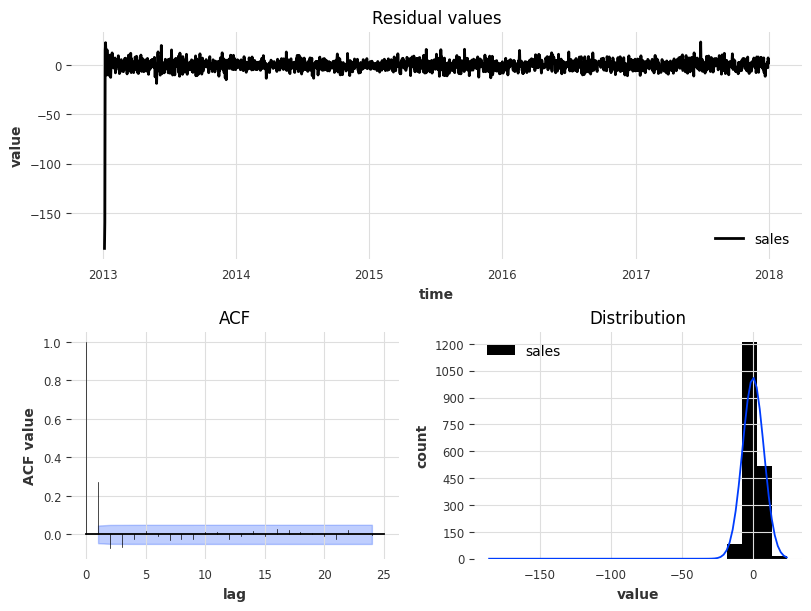

In [143]:
from darts.utils.statistics import plot_residuals_analysis
plot_residuals_analysis(model.residuals(series))

**Observations:**

**First Graph:** The residuals are close to zero for most of the time, but significant deviations are observed at the beginning of the time series (2013). This may indicate potential issues with the model at the start of the series, requiring further analysis and possibly data or model adjustments.

**Second Graph:** The autocorrelation of the residuals is within the confidence interval for most lags, indicating that the model effectively removed autocorrelation in the residuals. This is a good sign as it suggests the absence of significant dependencies in the residuals that were accounted for by the model.

**Third Graph:** The residuals are mainly distributed around zero, and their distribution resembles a normal distribution (with a few outliers). However, there are some strong deviations, which may indicate the presence of extreme values that could impair the model's forecasts.


**Conclusion:**

The model shows satisfactory results regarding residuals; however, there are indications that it might struggle with anomalies or trend changes at the beginning of the time series. This may require additional tuning or consideration of alternative models to better account for anomalous data or changes in sales patterns.


17. На цьому етапі ви зрозуміли, як моделювати продажі одного айтему з 1 магазину. Як би ви підійшли до задачі прогнозування продажів в наступному місяці для кожного з 50 айтемів в кожному з 10 магазинів? Опишіть загальний підхід
- яку модель ви б використали
- скільки моделей ви б тренували
- обгрунтуйте свій вибір.

**Model Selection and Rationale**

For the task of sales forecasting, I propose using Prophet and XGBoost based on their demonstrated effectiveness in previous analyses. Each model offers unique advantages:

**Prophet:**

Designed explicitly for time series data, it excels in modeling seasonal patterns and long-term trends.
It is particularly robust for handling missing data and irregular time intervals, which are common in sales datasets.

**XGBoost:**

A gradient boosting framework that effectively models complex, non-linear relationships.
Its flexibility allows for the incorporation of multiple covariates, such as promotional campaigns, pricing, weather conditions, and store-specific factors.

**Refinement of Prophet Model**

To enhance the performance of Prophet for this dataset, I recommend the following methodological adjustments:

1. Reducing Sensitivity to Anomalies

Anomalies in time series data, such as extreme sales spikes, can distort trend and seasonal estimates.

Adjusting the changepoint_prior_scale parameter controls the model's sensitivity to abrupt changes, ensuring smoother trend predictions.

2. Advanced Data Preprocessing

Outlier Detection: Employ statistical techniques (e.g., IQR, Z-scores) or machine learning algorithms (e.g., Isolation Forest, LOF) to identify and remove outliers systematically.

Imputation of Missing Values: Use interpolation methods such as linear, spline, or Kalman filters to handle gaps in the time series data.

3. Residual Analysis for Anomaly Identification

After initial model fitting, examine residuals to pinpoint anomalous points where the model underperforms.

Consider these anomalies separately in downstream modeling by categorizing them into known external events or data inconsistencies.

**Modeling Strategy**

A hierarchical modeling approach will be adopted to capture both global patterns and local variations in the data. This involves training individual models for each item-store pair, resulting in a total of 500 models (50 items × 10 stores). The rationale for this approach is grounded in the heterogeneity of sales dynamics:

1. Item-Level Variations:
Different items exhibit distinct seasonalities, influenced by factors such as perishability, demand cycles, and consumer preferences.
2. Store-Level Variations:
Geographic location, customer demographics, and localized promotions significantly influence sales patterns across stores.
3. Cross-Interaction Effects:
Interactions between items and stores (e.g., a popular item performing differently in urban vs. rural settings) necessitate individualized modeling to capture these nuances.

**Integration of Additional Features in XGBoost**

To complement the temporal forecasts generated by Prophet, XGBoost will incorporate exogenous variables to model residual dependencies and enhance predictive accuracy. Potential features include:

1. Promotional Indicators: Binary or categorical variables indicating marketing campaigns.
2. Weather Conditions: Temperature, precipitation, and seasonal factors impacting consumer behavior.
3. Economic Indicators: Inflation rates, unemployment levels, or regional income data.
4. Day-of-Week and Holiday Effects: Encoding these as categorical variables to capture periodic demand shifts.

**Model Tuning and Validation**

**Hyperparameter Optimization:**

For Prophet: Optimize changepoint_prior_scale, seasonality_prior_scale, and holidays_prior_scale.

For XGBoost: Tune parameters such as max_depth, learning_rate, and subsample using cross-validation.

**Validation Framework:**

Employ a rolling window validation approach, splitting the data into training and testing sets over successive time intervals to ensure robust generalization.

**Justification of Hybrid Approach**

Combining Prophet and XGBoost leverages their respective strengths:

Prophet identifies and models intrinsic temporal patterns (seasonality, trend).

XGBoost addresses residual complexities by incorporating external factors and capturing non-linear relationships.

**Conclusion:**

By employing a scientifically rigorous approach that integrates model refinement, feature engineering, and hierarchical modeling, this methodology is poised to deliver high-resolution forecasts that account for both global trends and localized variations. Such a hybrid system ensures robust predictive performance, adaptability, and actionable insights for sales optimization.